In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import numpy as np
import csv
from tqdm import tqdm


# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    city = [scene['city'] for scene in batch]
    scene_idx = [scene['scene_idx'] for scene in batch]
    agent_id = [scene['agent_id'] for scene in batch]
    car_mask = [scene['car_mask'] for scene in batch]
    track_id = [scene['track_id'] for scene in batch]
    pin = [scene['p_in'] for scene in batch]
    vin = [scene['v_in'] for scene in batch]
    pout = [scene['p_out'] for scene in batch]
    vout = [scene['v_out'] for scene in batch]
    lane = [scene['lane'] for scene in batch]
    lane_norm = [scene['lane_norm'] for scene in batch]
    
    
    return [city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm]


def my_collate_for_csv(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    city = [scene['city'] for scene in batch]
    scene_idx = [scene['scene_idx'] for scene in batch]
    agent_id = [scene['agent_id'] for scene in batch]
    car_mask = [scene['car_mask'] for scene in batch]
    track_id = [scene['track_id'] for scene in batch]
    pin = [scene['p_in'] for scene in batch]
    vin = [scene['v_in'] for scene in batch]
    lane = [scene['lane'] for scene in batch]
    lane_norm = [scene['lane_norm'] for scene in batch]
    
    
    return [city, scene_idx, agent_id, car_mask, track_id, pin, vin, lane, lane_norm]

def conv_pos_to_disp(x, last_known=None, use_known = False):
    arr = np.zeros(x.shape)
    for i in range(arr.shape[0]):
        if not use_known:
            for j in range(1, arr.shape[2]):
                arr[i, :, j, :] = x[i, :, j, :] - x[i, :, j - 1, :]
        else:
            for j in range(0, arr.shape[2]):
                arr[i, :, j, :] = x[i, :, j, :] - x[i, :, j - 1, :]
    return arr

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RNN(nn.Module):
    def __init__(self, input_size=120, num_layers=2, hidden_size=256):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm1 = nn.LSTMCell(input_size, 256)
        self.lstm2 = nn.LSTMCell(256, 512)
        self.fc1 = nn.Linear(512, 1024)
        self.fc6 = nn.Linear(1024, 1024)
        self.lstm3 = nn.LSTMCell(1024, 512)
        self.lstm4 = nn.LSTMCell(512, 256)
        self.fc7 = nn.Linear(256, 256)
        self.fc8 = nn.Linear(256, 120)
        self.do = nn.Dropout(p = 0.01)
        self.sm = nn.LogSoftmax()
        
    def forward(self, x, future=0):
        x = x.float()
        outputs = []
        n_samples = x.size(0)
        
        ht = torch.zeros(n_samples, 256, dtype=torch.float32).to(device)
        ct = torch.zeros(n_samples, 256, dtype=torch.float32).to(device)
        ht2 = torch.zeros(n_samples, 512, dtype=torch.float32).to(device)
        ct2 = torch.zeros(n_samples, 512, dtype=torch.float32).to(device)
        ht3 = torch.zeros(n_samples, 512, dtype=torch.float32).to(device)
        ct3 = torch.zeros(n_samples, 512, dtype=torch.float32).to(device)
        ht4 = torch.zeros(n_samples, 256, dtype=torch.float32).to(device)
        ct4 = torch.zeros(n_samples, 256, dtype=torch.float32).to(device)

        for input_t in x.split(1, dim=1):
            input_t = input_t.reshape((n_samples, 120))
            ht, ct = self.lstm1(input_t, (ht, ct))
            ht2, ct2 = self.lstm2(ht, (ht2, ct2))
            out = F.relu(self.fc1(ht2))
            self.do(out)
            out = F.relu(self.fc6(out))
            ht3, ct3 = self.lstm3(out, (ht3, ct3))
            ht4, ct4 = self.lstm4(ht3, (ht4, ct4))
            out = self.fc7(ht4)
            out = self.fc8(out)
#             outputs.append(out)
        
        for i in range(future):
            ht, ct = self.lstm1(input_t, (ht, ct))
            ht2, ct2 = self.lstm2(ht, (ht2, ct2))
            out = F.relu(self.fc1(ht2))
            self.do(out)
            out = F.relu(self.fc6(out))
            ht3, ct3 = self.lstm3(out, (ht3, ct3))
            ht4, ct4 = self.lstm4(ht3, (ht4, ct4))
            out = self.fc7(ht4)
            out = self.fc8(out)
            outputs.append(out)
            
#         print(outputs)
            
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [3]:
RMSE = []

In [4]:
#### from tqdm import tqdm_notebook as tqdm
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
#     model = RNN().to(device)
#     model.load_state_dict(torch.load("MODEL"))
    model.train()
    iterator = tqdm(train_loader, total=int(len(train_loader)))
    
    total = 0
    count = 0
    for batch_idx, batch in enumerate(iterator):
        
#         if count >= 100:
#             break
        
        city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm = batch
        pin = np.array(pin)
        pout = np.array(pout)
        vin = np.array(vin)
        vout = np.array(vout)
        car_mask = np.array(car_mask)
            
        pin = conv_pos_to_disp(pin)
        last_known = pin[:, :, 18, :]
        pout = conv_pos_to_disp(pout, last_known, True)
        
        pin = pin.reshape((len(agent_id), 19, 120))
        pout = pout.reshape((len(agent_id), 3600))
        
        data = torch.from_numpy(pin)
        target = torch.from_numpy(pout)
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, 30)

        target = target.float()
        
        loss = nn.MSELoss()(output, target)
        
        eps = 1e-6
        rmse = torch.sqrt(loss + eps)
        RMSE.append(rmse.item())
        
        loss.backward()
        optimizer.step()
    
        total += loss.item()
        count += 1
        iterator.set_postfix_str("loss={}, avg.={}".format(loss.item(), total/count))

In [5]:
def test(model, device, test_loader):
#     model = RNN().to(device)
#     model.load_state_dict(torch.load("MODEL"))
    model.eval()
    test_loss = 0
    total_dist = 0
    num_tested = 0
    with torch.no_grad():
        iterator = tqdm(test_loader, total=int(100))
        for batch_idx, batch in enumerate(iterator):
            
            if num_tested >= 100:
                break;
            
            city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm = batch
            pin = np.array(pin)
            pout = np.array(pout)
            vin = np.array(vin)
            vout = np.array(vout)
            car_mask = np.array(car_mask)
           
            pin = conv_pos_to_disp(pin)
            last_known = pin[:, :, 18, :]
            pout = conv_pos_to_disp(pout, last_known, True)

            pin = pin.reshape((len(agent_id), 19, 120))
            pout = pout.reshape((len(agent_id), 3600)) # 30x120

            data = torch.from_numpy(pin)
            target = torch.from_numpy(pout)
            
            data, target = data.to(device), target.to(device)
            output = model(data, 30)
            
            target = target.float()
            
            num_tested += 1
            test_loss += nn.MSELoss()(output, target).item() # sum up batch loss
            
    test_loss /= num_tested
    print("Test loss: {}".format(test_loss))

In [6]:
learning_rate = 0.001
momentum = 0.5
device = "cuda"
model = RNN().to(device) #using cpu here
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_sz = 100
num_epoch = 10

print(sum(p.numel() for p in model.parameters()))


new_path = "./new_train/new_train/"
val_dataset  = ArgoverseDataset(data_path=new_path)
dataset_len = len(val_dataset)
indices = np.arange(0, len(val_dataset))
np.random.shuffle(indices)

# train_loader = DataLoader(val_dataset, batch_size=batch_sz, collate_fn=my_collate, num_workers=1,
#                          sampler=torch.utils.data.SubsetRandomSampler(indices[:int(dataset_len*0.8)]))
# test_loader = DataLoader(val_dataset, batch_size=batch_sz, collate_fn=my_collate, num_workers=1,
#                         sampler=torch.utils.data.SubsetRandomSampler(indices[int(dataset_len*0.8):]))


train_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=1)
test_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle=True, collate_fn=my_collate, num_workers=1)

# do_both(model, device, train_loader, test_loader, optimizer, epoch)

PATH = "RNN-Linear-v02(big boi).pth"
# model.load_state_dict(torch.load(PATH))

# validation_err = 10000
# num_valids_wrong = 0

for epoch in range(1, num_epoch + 1):
    print("EPOCH: {} -----------------------------------".format(epoch))
    train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)
    torch.save(model.state_dict(), PATH)

7573880


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 1 -----------------------------------


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 2 -----------------------------------


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 3 -----------------------------------


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 4 -----------------------------------


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 5 -----------------------------------


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 6 -----------------------------------


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 7 -----------------------------------


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 8 -----------------------------------


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 9 -----------------------------------


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 10 -----------------------------------


100%|██████████| 2060/2060 [07:07<00:00,  4.81it/s, loss=0.14655175805091858, avg.=0.13504835378053118]


In [19]:
def conv_disp_to_pos(x, last_known):
#     print("cdtp: {}".format(x.shape))
    x[0, :] += last_known
    for i in range(1, 30):
        x[i, :] += x[i - 1, :]
    return x

def create_csv_for_vals(model, device, loader):#     model = RNN().to(device)
    with open('csv_submission.csv', 'w') as csv_sub_wrap:
        csv_sub = csv.writer(csv_sub_wrap)
        
        first_row = ["ID",  "v1",  "v2",  "v3",  "v4",  "v5",  "v6",  "v7",  "v8",  "v9",  "v10",  "v11",  "v12",  "v13",  "v14",  "v15",  "v16",  "v17",  "v18",  "v19",  "v20",  "v21",  "v22",  "v23",  "v24",  "v25",  "v26",  "v27",  "v28",  "v29",  "v30",  "v31",  "v32",  "v33",  "v34",  "v35",  "v36",  "v37",  "v38",  "v39",  "v40",  "v41",  "v42",  "v43",  "v44",  "v45",  "v46",  "v47",  "v48",  "v49",  "v50",  "v51",  "v52",  "v53",  "v54",  "v55",  "v56",  "v57",  "v58",  "v59",  "v60"]
        csv_sub.writerow(first_row)
        
        model.eval()
        with torch.no_grad():
            iterator = tqdm(loader, total=int(len(loader)))
            for batch_idx, batch in enumerate(iterator):
                city, scene_idx, agent_id, car_mask, track_id, pin, vin, lane, lane_norm = batch
                pin = np.array(pin)

                pin2 = pin
                pin = conv_pos_to_disp(pin)

                pin = pin.reshape((len(agent_id), 19, 120))

                data = torch.from_numpy(pin)

                data = data.to(device)
                output = model(data, 30)

                output = output.reshape((len(agent_id), 60, 30, 2)).cpu().numpy()                

                for i in range(len(agent_id)):
                    agent_index = np.where(track_id[i] == agent_id[i])[0][0]
                    last_known = pin2[i, agent_index, 18, :]
#                     print(last_known)
                    pout = conv_disp_to_pos(output[i, agent_index, :, :], last_known)
                    pout = pout.reshape((60))
                    out = []
                    for j in range(61):
                        out.append(1)
                    out[0] = scene_idx[i]
                    out[1:] = pout
                    csv_sub.writerow(out)
#                     csv_sub.writerow([scene_idx[i], pout])
#                     csv_sub.write(scene_idx)
#                     csv_sub.writerow(pout)

def visualize(model, device, loader):
    model.eval()
    with torch.no_grad():
        iterator = tqdm(loader, total=int(len(loader)))
        for batch_idx, batch in enumerate(iterator):
            city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm = batch
            pin = np.array(pin)

            pin2 = pin
            pin = conv_pos_to_disp(pin)

            pin = pin.reshape((len(agent_id), 19, 120))

            data = torch.from_numpy(pin)

            data = data.to(device)
            output = model(data, 30)

            output = output.reshape((len(agent_id), 60, 30, 2)).cpu().numpy()                
                
            
            batch_sz = len(agent_id)
            fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = .5, wspace=.001)
            axs = axs.ravel()   
            for i in range(batch_sz):
                axs[i].xaxis.set_ticks([])
                axs[i].yaxis.set_ticks([])
                
                agent_index = np.where(track_id[i] == agent_id[i])[0][0]
                last_known = pin2[i, agent_index, 18, :]
#                     print(last_known)
                pred = conv_disp_to_pos(output[i, agent_index, :, :], last_known)

                # first two feature dimensions are (x,y) positions
                axs[i].scatter(pin2[i, agent_id[i],:,0], pin2[i, agent_id[i],:,1])
                axs[i].scatter(pout[i, agent_id[i],:,0], pout[i, agent_id[i],:,1])
                axs[i].scatter(pred[i, agent_id[i],:,0], pred[i, agent_id[i],:,1])

In [20]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

7573880


  0%|          | 0/102971 [00:00<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

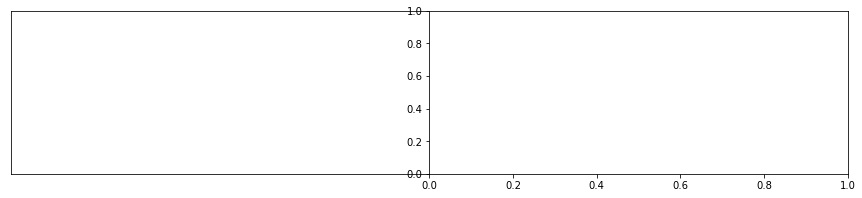

In [21]:
learning_rate = 0.001
momentum = 0.5
device = "cuda"
model = RNN().to(device) #using cpu here
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_sz = 2
num_epoch = 10

print(sum(p.numel() for p in model.parameters()))

# new_path = "./new_val_in/new_val_in/"

# val_dataset  = ArgoverseDataset(data_path=new_path)
# dataset_len = len(val_dataset)
# indices = np.arange(0, len(val_dataset))
# np.random.shuffle(indices)

# loader = DataLoader(val_dataset, batch_size=batch_sz, collate_fn=my_collate_for_csv, num_workers=1)


new_path = "./new_train/new_train/"
val_dataset  = ArgoverseDataset(data_path=new_path)
train_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=1)


# do_both(model, device, train_loader, test_loader, optimizer, epoch)
PATH = "RNN-Linear-v02(big boi).pth"
model.load_state_dict(torch.load(PATH))


visualize(model, device, train_loader)

# create_csv_for_vals(model, device, loader)

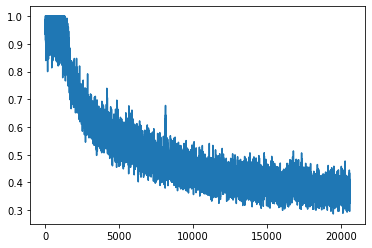

In [8]:
import matplotlib.pyplot as plt

RMSE_out = np.array(RMSE)
ones = np.ones((len(RMSE)))

RMSE_out = np.minimum(RMSE_out, ones)

plt.plot(RMSE_out)
plt.savefig('RNN-RMSE.png')